## Looping detector

In [25]:
from reader import Reader
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime
from datetime import date as date_creator
from numba import njit
import pandas as pd
import os
from numba import jit, njit
from sklearn.linear_model import LinearRegression

%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ModuleNotFoundError: No module named 'cartopy'

In [20]:
def smooth(x,window_len=11,window='hanning'):
        if x.ndim != 1:
                raise ValueError("smooth only accepts 1 dimension arrays.")
        if x.size < window_len:
                raise ValueError("Input vector needs to be bigger than window size.")
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]
def get_date_time_dif(start_time,stop_time):
    date = date_creator(1, 1, 1)
    datetime1 = datetime.combine(date, start_time)
    datetime2 = datetime.combine(date, stop_time)
    time_elapsed = datetime1 - datetime2
    return time_elapsed.total_seconds()
def compute_dist(lat1,lon1,lat2,lon2,rad=True):
    if not(rad):
        lat1 = radians(lat1)
        lon1 = radians(lon1)
        lat2 = radians(lat2)
        lon2 = radians(lon2)
    # approximate radius of earth in m
    R = 6373_000.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c
def remove_zero_from_alti(alti):
    if alti[0] < 10 :
        alti[0] = alti[1]
    if alti[-1] < 10 :
        alti[-1] = alti[-2]
    for i,alt in enumerate(alti):
        if alt < 10 :
            if i >= len(alti)-1 :
                alti[i] = (alti[i-1]+alti[i])/2
            else :  
                alti[i] = (alti[i-1]+alti[i+1])/2
    return alti

def read_igc(file):
    with open(file, 'r') as f:
        parsed_igc_file = Reader().read(f)
    # print('igc_file created')
    previous_lat = 0
    previous_lon = 0
    
    all_lon = np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_lat = np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_speed=np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_vz=np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_alti=np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_time=[0 for _ in range(len(parsed_igc_file['fix_records'][1]))]

    for i,record in enumerate(parsed_igc_file['fix_records'][1]):
        record['time'] = record['time'].replace(hour=record['time'].hour + 1)
        all_lat[i] = record['lat']
        all_lon[i] = record['lon']
        if previous_lon ==0 :
            previous_lat = record['lat']
            previous_lon = record['lon']
            previous_datetime = record['time']
            previous_alt_gps = record['gps_alt']
            # previous_alt_baro = record['pressure_alt']
            all_time[i] = record['time']
        else :
            dxy = abs(compute_dist(previous_lat,previous_lon,record['lat'],record['lon'],rad=False))
            # dz = previous_alt_baro-record['pressure_alt']
            dz = previous_alt_gps-record['gps_alt']
            dt = get_date_time_dif(record['time'],previous_datetime)
            # if dt>2 : print('dtttttt>2 ',dt)
            if dt>0 :
                all_speed[i] = min(100,dxy/dt*3.6)
                all_vz[i] = dz/dt
            all_alti[i] = record['gps_alt']
            all_time[i] = record['time']
            
            previous_lat = record['lat']
            previous_lon = record['lon']
            previous_datetime = record['time']
            previous_alt_gps = record['gps_alt']
            # previous_alt_baro = record['pressure_alt']

            # if previous_datetime.hour>10 :
            #     all_speed = all_speed[:i]
            #     all_vz = all_vz[:i]
            #     all_alti = all_alti[:i]
            #     break
#    return all_lon,all_lat,all_speed,all_vz,remove_zero_from_alti(all_alti),all_time
    return all_lon,all_lat,all_alti,all_time

def reshape_array(arr,time_vid):
    nb_img_by_sec = 24
    
    t_true = np.linspace(time_vid[0], time_vid[-1], num=len(time_vid), endpoint=True)
    t_inter = np.linspace(time_vid[0], time_vid[-1], num=int(len(time_vid)*nb_img_by_sec/speed_acc), endpoint=True)
    f = interp1d(t_true, arr, kind='cubic')

    return f(t_inter)

def smooth_igc_output(L_all):
    all_ret = []
    for l_val in L_all:
        l_val[0]=l_val[1]#=np.mean(l_val[:int(len(l_val)/10)])
        smoothed = smooth(l_val,50,'hanning')
        all_ret.append(smoothed)
    return all_ret

def plot_smooth_non_smooth(smooth,non_smooth):
    plt.figure(figsize=(18,9))
    plt.plot(non_smooth)
    plt.plot(smooth)
    plt.show()

def get_last_date_of_all_raw_file(path_raw_file):
    delta_time_writing = 20
    all_ending_time = []
    for file in os.listdir(path_raw_file):
        if "_11_" in file :
            time_end = os.path.getmtime(path_raw_file+'\\'+file)
            all_ending_time.append(datetime.fromtimestamp(time_end-delta_time_writing).time())
    return all_ending_time

def convert_time_to_sec(all_time):
    for i in range(len(all_time)):
        all_time[i] = all_time[i].hour*3600 + all_time[i].minute*60 + all_time[i].second
    return np.array(all_time,dtype=np.float32)

In [131]:
from os import listdir
from os.path import isfile, join
path = 'C:/Users/barroisl/Documents/Stage_Léo/Vols/IGC_20-08-2023/Parapente_old/'
#path = 'IGC_20-08-2023/'
#list_files = [path+f for f in listdir(path) if isfile(join(path, f))]
list_files = [f for f in listdir(path) if isfile(join(path, f))]

print(len(list_files))

72


In [132]:
file = '2023-08-20-XCT-BLA-01.igc'
path = 'C:/Users/barroisl/Documents/Stage_Léo/Vols/IGC_20-08-2023/Parapente_old/'
#all_lon,all_lat,speed_vid,vz_vid,alti_vid,time_vid,all_vz2,all_speed_smooth, all_vz_smooth, all_alti_smooth,all_alti = prep_file(path, file)
all_lon,all_lat,all_alti,all_time = read_igc(join(path,file))

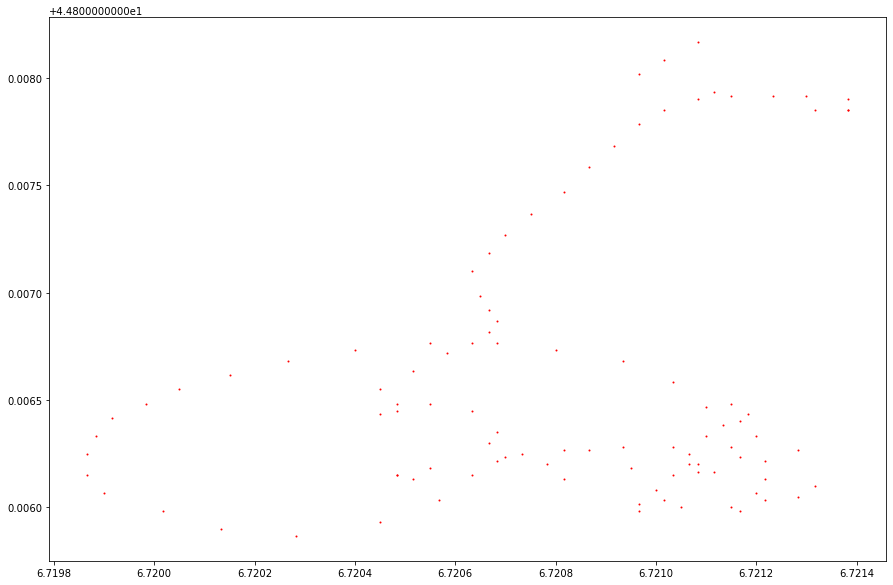

In [23]:
fig = plt.figure(figsize=(15,10))
img_extent = (4.7942, 8.1545, 43.3545, 46.6707)
#img_extent = (-5.5, 8, 42, 51.5)

fname = 'C:/Users/barroisl/Documents/Stage_Léo/Satellites/Images_MODIS_VIIRS/Alp_2023-08-20_12H28.jpg'
#fname = 'T:/C2H/STAGES/LEO_BARROIS/PIA03393.tif'

#mg = plt.imread(fname)

#ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())
plt.scatter(all_lon[150:250],all_lat[150:250],s=1,color = 'r')
plt.show()

In [7]:
n = len(all_lat)
theta = np.zeros((1,n-1))
for j in range(n-1):
        theta[0,j] = np.arctan((all_lat[j+1]-all_lat[j])/(all_lon[j+1]-all_lon[j]))

C:\Users\barroisl\AppData\Local\Temp\ipykernel_15148\2561646321.py:4: RuntimeWarning: invalid value encountered in double_scalars
  theta[0,j] = np.arctan((all_lat[j+1]-all_lat[j])/(all_lon[j+1]-all_lon[j]))
C:\Users\barroisl\AppData\Local\Temp\ipykernel_15148\2561646321.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  theta[0,j] = np.arctan((all_lat[j+1]-all_lat[j])/(all_lon[j+1]-all_lon[j]))


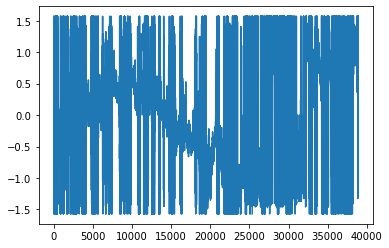

In [8]:
plt.plot(theta[0])

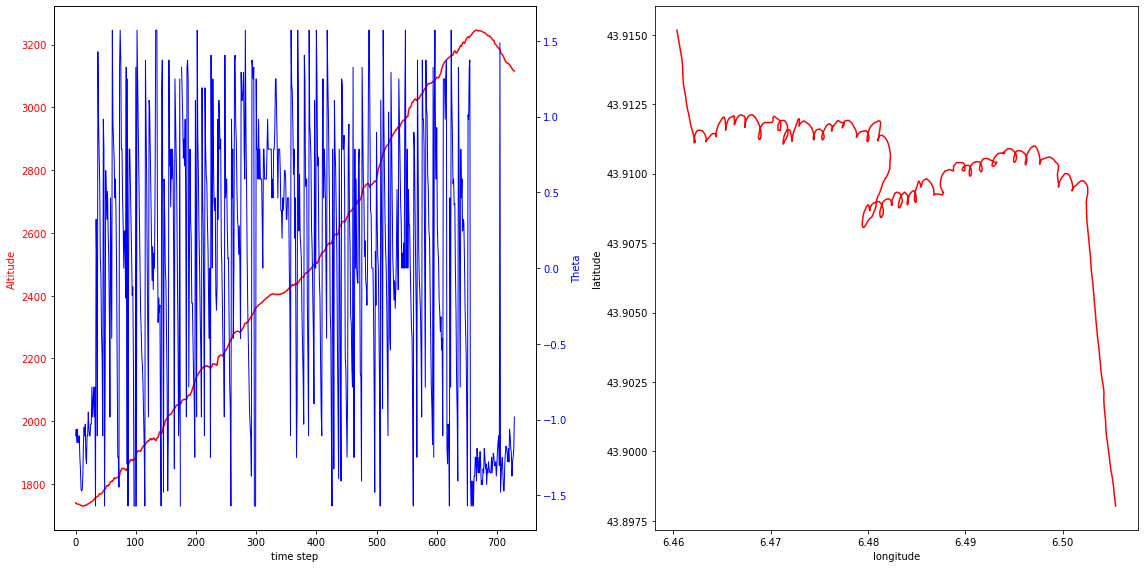

In [9]:
ext = [22770,23500]

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(16, 8))

ax1.set_xlabel('time step') 
ax1.set_ylabel('Altitude', color = 'red') 
ax1.plot(all_alti[ext[0]:ext[1]],'r') 
ax1.tick_params(axis ='y', labelcolor = 'red') 

# Create a twin axis sharing the x-axis with ax1
ax2 = ax1.twinx() 
ax2.set_ylabel('Theta', color = 'blue') 
ax2.plot(theta[0,ext[0]:ext[1]],'b',linewidth = 1)
ax2.tick_params(axis ='y', labelcolor = 'blue') 

# Plot on the second subplot
ax3.plot(all_lon[ext[0]:ext[1]], all_lat[ext[0]:ext[1]], 'r-')
ax3.set_xlabel('longitude')
ax3.set_ylabel('latitude')
plt.tight_layout()

plt.show()


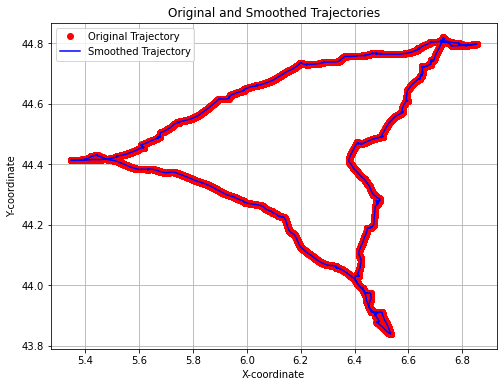

In [10]:
from scipy.interpolate import CubicSpline
n = len(all_lat)
ext = [0,n]
length = ext[1]-ext[0]
t = np.linspace(0, length, length)  # Time points
spline_lon = CubicSpline(t, all_lon[ext[0]:ext[1]])
spline_lat = CubicSpline(t, all_lat[ext[0]:ext[1]])

# Define finer time points for interpolation
t_interp = np.linspace(0, length, length*100)

# Interpolate smoothed trajectories
lon_interp = spline_lon(t_interp)
lat_interp = spline_lat(t_interp)

# Plot original and smoothed trajectories
plt.figure(figsize=(8, 6))
plt.plot(all_lon[ext[0]:ext[1]], all_lat[ext[0]:ext[1]], 'ro', label='Original Trajectory')
plt.plot(lon_interp, lat_interp, 'b-', label='Smoothed Trajectory')
plt.title('Original and Smoothed Trajectories')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.grid(True)
plt.show()


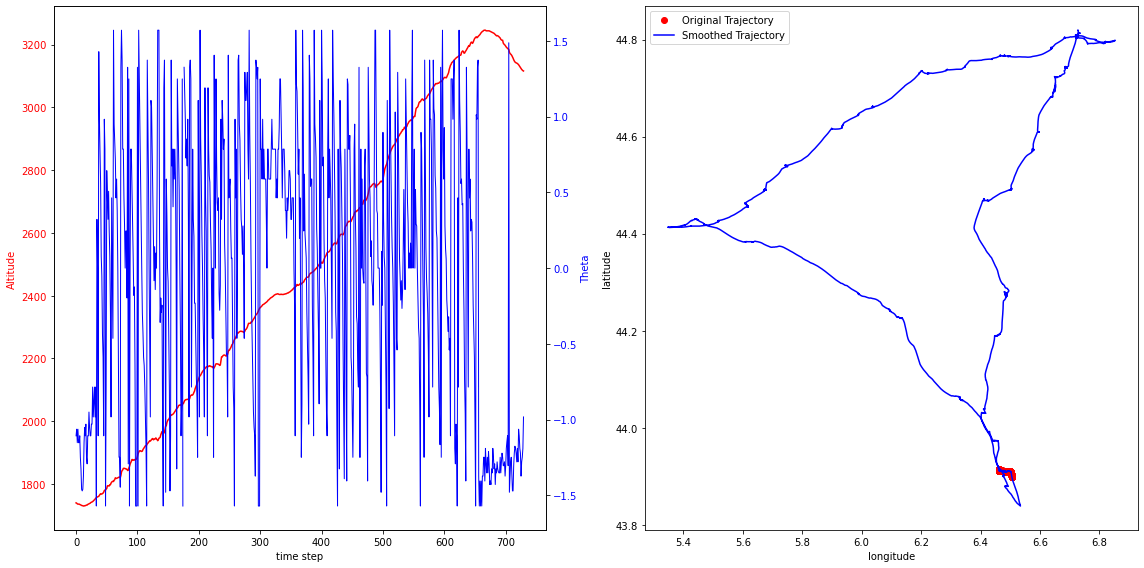

In [11]:
ext = [22770,23500]

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(16, 8))

ax1.set_xlabel('time step') 
ax1.set_ylabel('Altitude', color = 'red') 
ax1.plot(all_alti[ext[0]:ext[1]],'r') 
ax1.tick_params(axis ='y', labelcolor = 'red') 

# Create a twin axis sharing the x-axis with ax1
ax2 = ax1.twinx() 
ax2.set_ylabel('Theta', color = 'blue') 
ax2.plot(theta[0,ext[0]:ext[1]],'b',linewidth = 1)
ax2.tick_params(axis ='y', labelcolor = 'blue') 

# Plot on the second subplot
ax3.plot(all_lon[ext[0]:ext[1]], all_lat[ext[0]:ext[1]], 'ro', label='Original Trajectory')
ax3.plot(lon_interp, lat_interp, 'b-', label='Smoothed Trajectory')
ax3.set_xlabel('longitude')
ax3.set_ylabel('latitude')
ax3.legend()
plt.tight_layout()

plt.show()

In [13]:
n = len(lat_interp)
theta_interp = np.zeros((1,n-1))
for j in range(n-1):
        theta_interp[0,j] = np.arctan((lat_interp[j+1]-lat_interp[j])/(lon_interp[j+1]-lon_interp[j]))

C:\Users\barroisl\AppData\Local\Temp\ipykernel_15148\2718515642.py:4: RuntimeWarning: invalid value encountered in double_scalars
  theta_interp[0,j] = np.arctan((lat_interp[j+1]-lat_interp[j])/(lon_interp[j+1]-lon_interp[j]))
C:\Users\barroisl\AppData\Local\Temp\ipykernel_15148\2718515642.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  theta_interp[0,j] = np.arctan((lat_interp[j+1]-lat_interp[j])/(lon_interp[j+1]-lon_interp[j]))


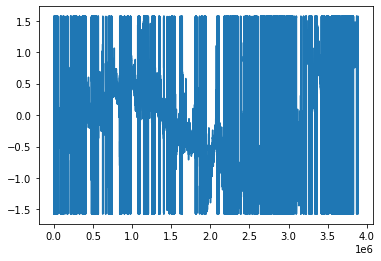

In [14]:
plt.plot(theta_interp[0])

In [188]:
def find_large_trends(time_series, window_size = 50):
    slopes = []
    for i in range(len(time_series) - window_size):
        window = time_series[i:i+window_size]
        x = np.linspace(1,window_size,window_size)
        x = x.reshape(-1,1)
        model = LinearRegression()
        model.fit(x, time_series[i:i+window_size])
        slopes.append(model.coef_[0])
    return slopes

@njit
def intervals(time_series_slopes, length, threshold = 1):
    indices = []
    i = 0
    while i < len(time_series_slopes) :
        k = 0
        while time_series_slopes[i+k] > threshold :
            k +=1
        if k >= length :
            indices.append((i,i+k))
        i = i+k+1
    return np.array(indices)

def find_major_increasing_trends(signal, length):
    slopes = find_large_trends(signal, window_size = 50)
    durations_interv = intervals(slopes, length, threshold = 1)
    return durations_interv

In [193]:
extents = find_major_increasing_trends(all_alti, 200)
extents_2 = find_major_increasing_trends(all_alti, 50)

In [194]:
print(len(extents))
print(len(extents_2))

21
64


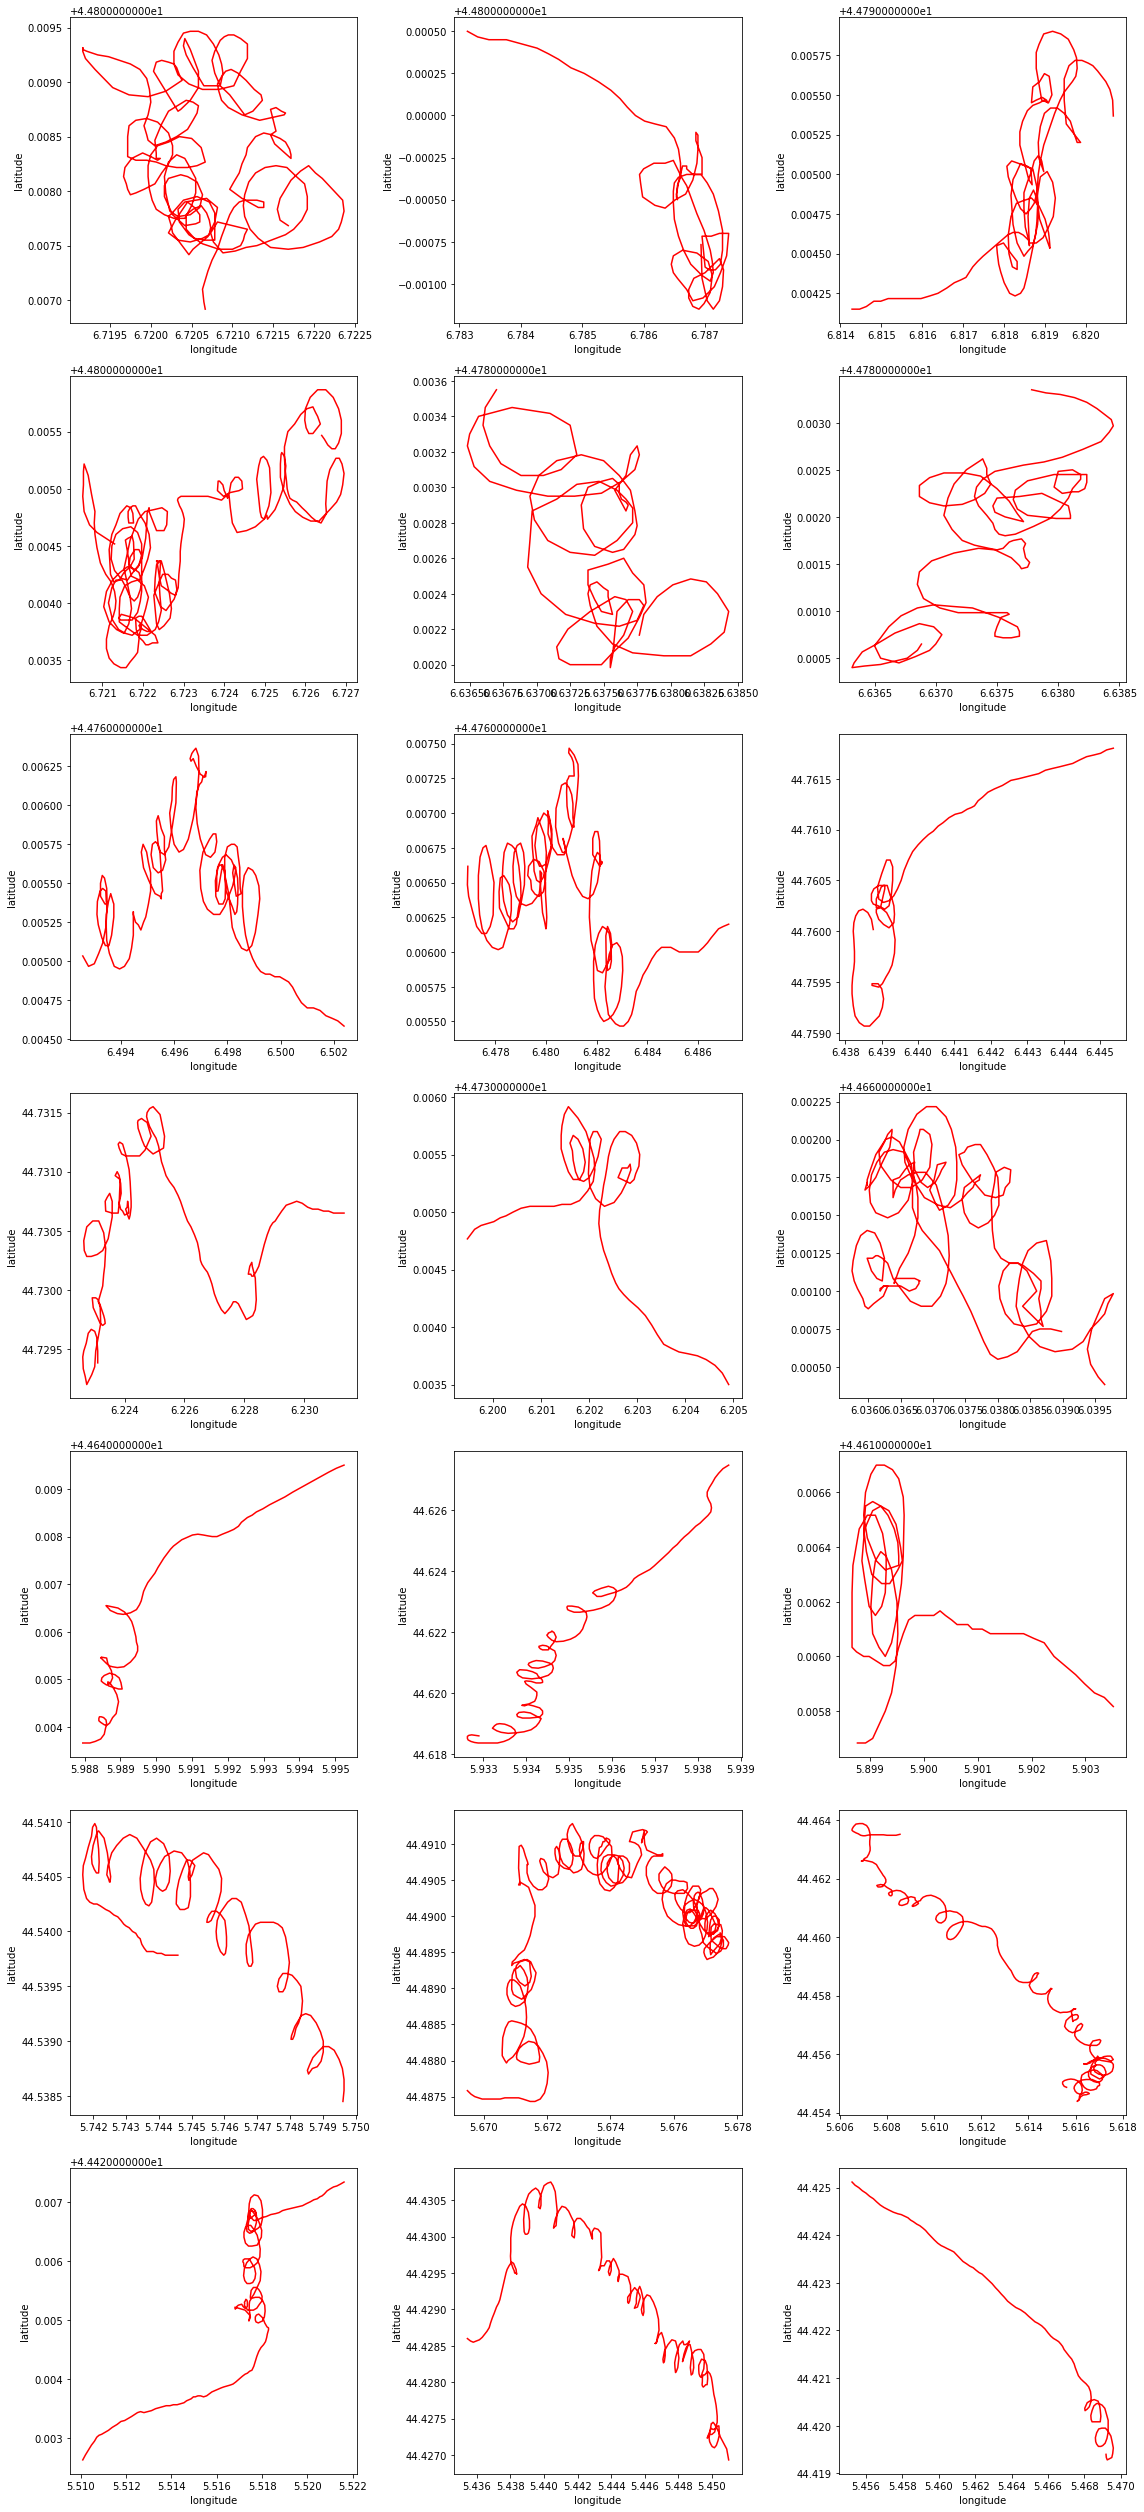

In [192]:
fig, axs = plt.subplots(7, 3, figsize=(16, 35))
model = LinearRegression()

for i in range(21):
    ax = axs[i//3,i%3]
    ext = extents_2[i]
    ax.plot(all_lon[ext[0]:ext[1]], all_lat[ext[0]:ext[1]], 'r-')
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
#    ax.set_title(str(i) + ' ' + str(all_time[extents[i,0]]) + '-' +str(all_time[extents[i,1]]),fontsize=15)
        
    x = np.linspace(ext[0],ext[1]-ext[0],ext[1]-ext[0])
    x = x.reshape(-1,1)
    model = LinearRegression()
    model.fit(x, all_lat[ext[0]:ext[1]])
    slopes = []
    slopes.append((model.coef_[0],model.intercept_))
    
#    ax.plot(all_lon[ext[0]:ext[1]], slopes[0]*all_lon[ext[0]:ext[1]]+slopes[1]+all_lon[ext[0]]-slopes[0]*all_lon[ext[0]],'darkorange')

plt.tight_layout()
plt.show()

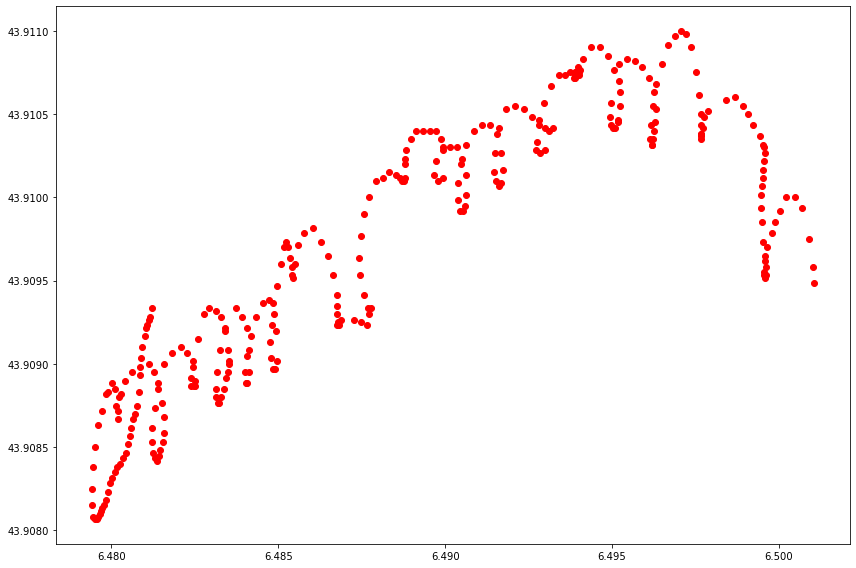

In [66]:
fig =  plt.figure(figsize=(12, 8))
slopes = []
model = LinearRegression()

ext = extents[16]
plt.plot(all_lon[ext[0]:ext[1]], all_lat[ext[0]:ext[1]], 'ro')

x = np.linspace(ext[0],ext[1]-ext[0],ext[1]-ext[0])
x = x.reshape(-1,1)
model = LinearRegression()
model.fit(x, all_lat[ext[0]:ext[1]])
slopes.append((model.coef_[0],model.intercept_))

ax.plot(all_lon[ext[0]:ext[1]], slopes[0]*(all_lon[ext[0]:ext[1]]-all_lon[ext[0]])+slopes[1]+all_lon[ext[0]],'darkorange')

plt.tight_layout()
plt.show()

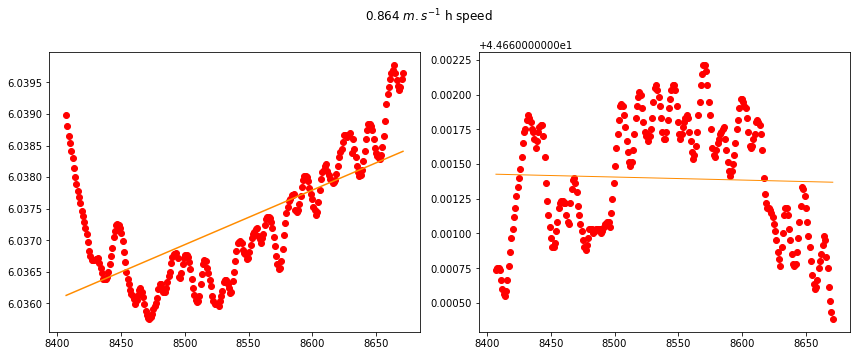

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

slopes = []
model = LinearRegression()

ext = extents[4]
x = np.linspace(ext[0],ext[1],ext[1]-ext[0])
axs[0].plot(x, all_lon[ext[0]:ext[1]], 'ro')
axs[1].plot(x, all_lat[ext[0]:ext[1]], 'ro')

x_reg = x.reshape(-1,1)

model = LinearRegression()
model.fit(x_reg, all_lon[ext[0]:ext[1]])
slopes.append((model.coef_[0],model.intercept_))
axs[0].plot(x, slopes[0][0]*x+slopes[0][1],'darkorange')

model = LinearRegression()
model.fit(x_reg, all_lat[ext[0]:ext[1]])
slopes.append((model.coef_[0],model.intercept_))
axs[1].plot(x, slopes[1][0]*x+slopes[1][1],linewidth = 1,color='darkorange')

mean_speed = np.sqrt((slopes[1][0]*100*1000)**2 + (slopes[0][0]*100*1000)**2)

fig.suptitle(str(mean_speed)[:5]+' $m.s^{-1}$ h speed')

plt.tight_layout()
plt.show()

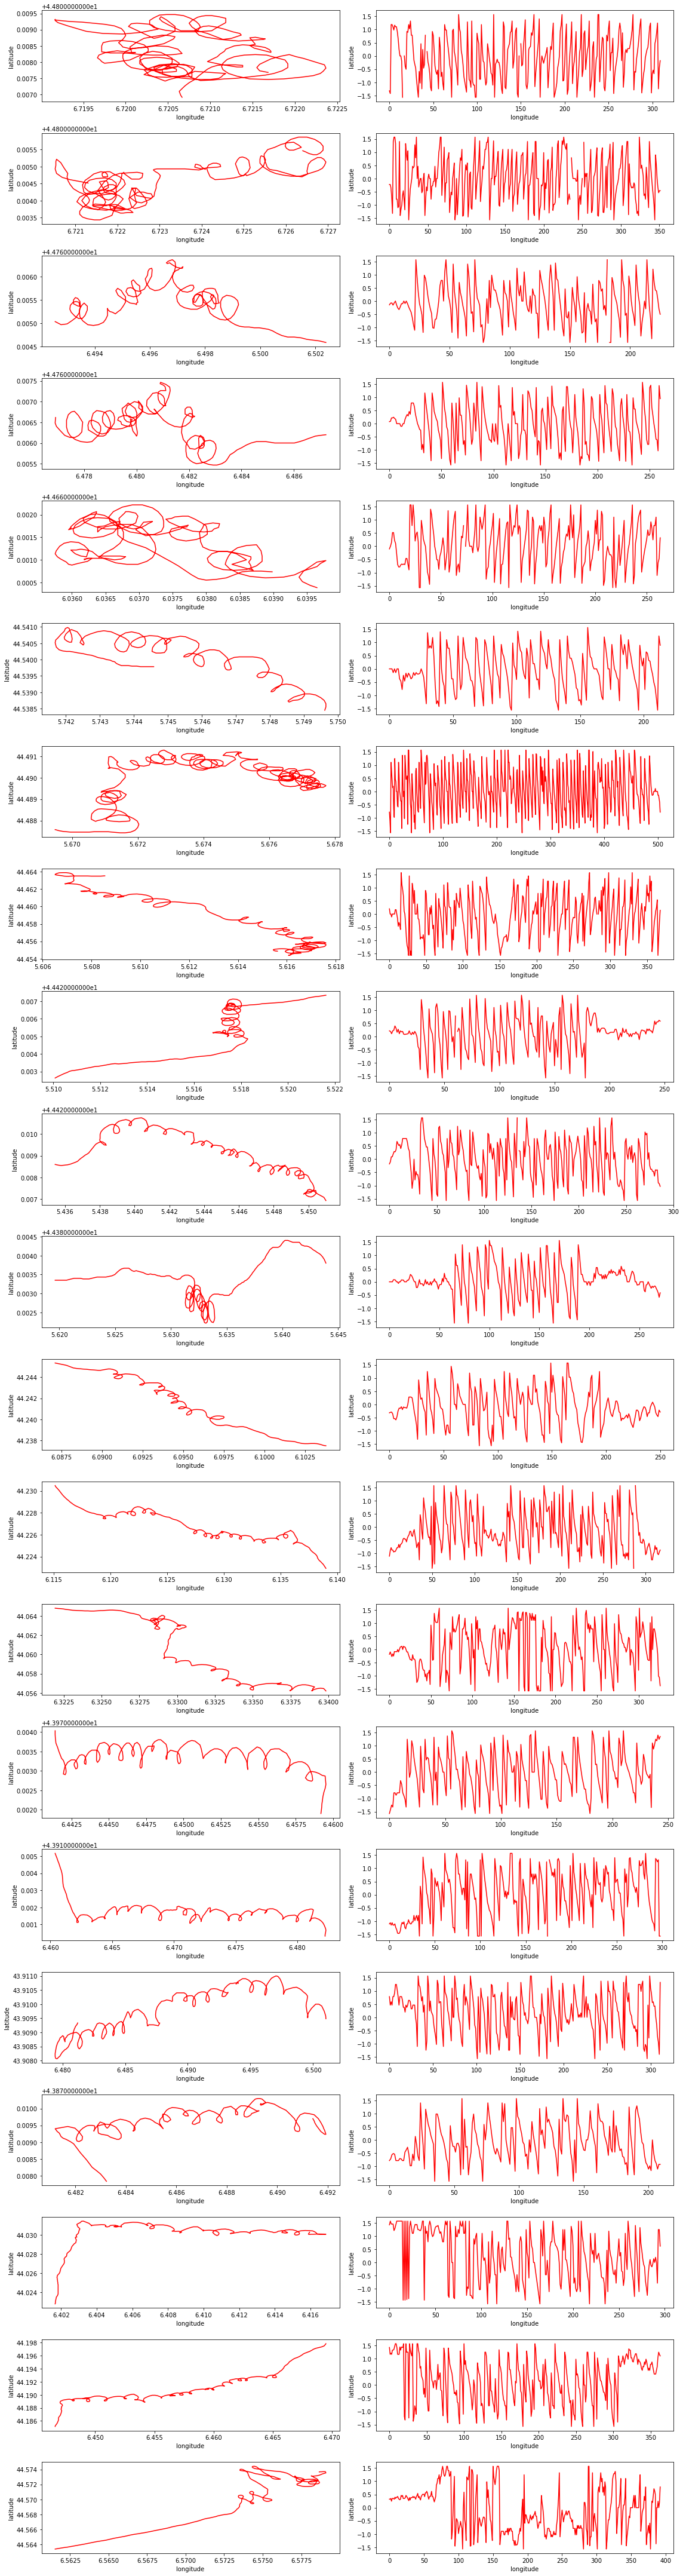

In [113]:
fig, axs = plt.subplots(21, 2, figsize=(16, 60))

for i in range(42):
    ax = axs[i//2,i%2]
    ext = extents[i//2]

    if i%2 == 0:
        ax.plot(all_lon[ext[0]:ext[1]], all_lat[ext[0]:ext[1]], 'r-')
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
#        ax.set_title(str(i) + ' ' + str(all_time[extents[i,0]]) + '-' +str(all_time[extents[i,1]]),fontsize=15)
        
    elif i%2 == 1:
        ax.plot(theta[0,ext[0]:ext[1]], 'r-')
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
#        ax.set_title(str(i) + ' ' + str(all_time[extents[i,0]]) + '-' +str(all_time[extents[i,1]]),fontsize=15)

plt.tight_layout()
plt.show()

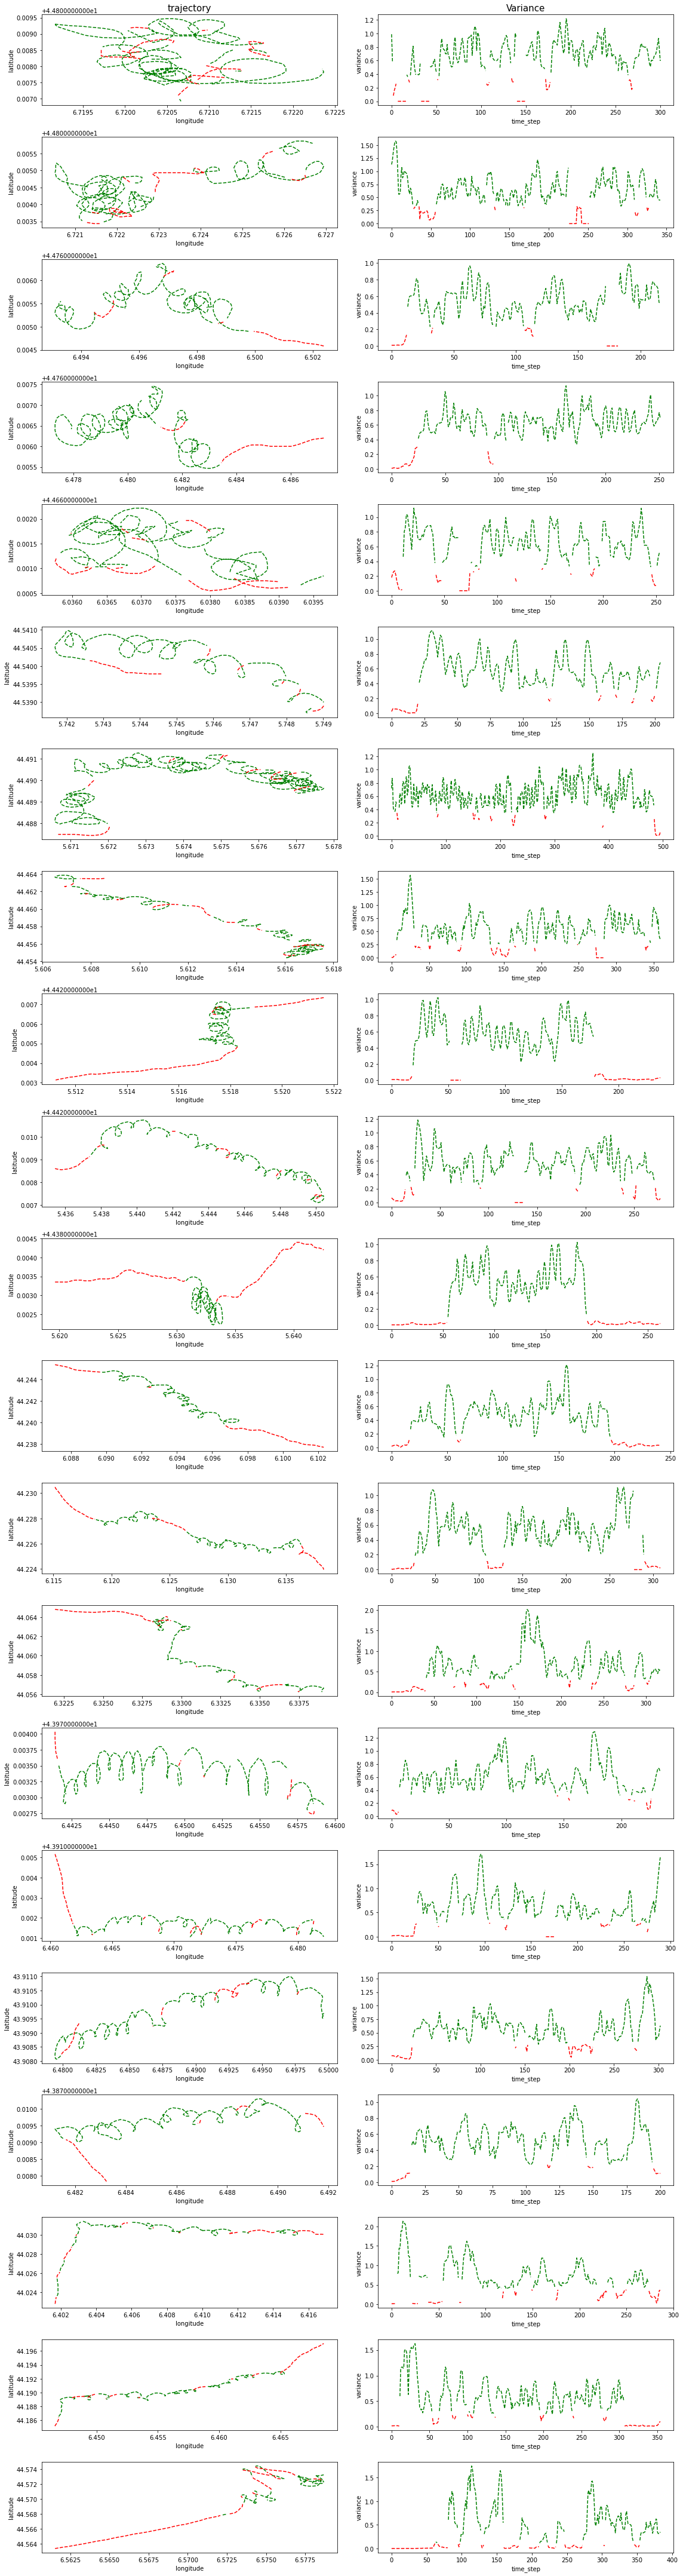

In [37]:
@njit
def rolling_variance(data, window_size):
    variance = np.zeros(len(data) - window_size + 1)
    for i in range(len(data) - window_size + 1):
        variance[i] = np.var(data[i:i+window_size])
    return variance

@njit
def rolling_mean(data, window_size):
    variance = np.zeros(len(data) - window_size + 1)
    for i in range(len(data) - window_size + 1):
        variance[i] = np.mean(data[i:i+window_size])
    return variance

fig, axs = plt.subplots(21, 2, figsize=(16, 60))
window_size = 10
threshold = 0.25

for i in range(42):
    ax = axs[i//2,i%2]
    ext = extents[i//2]
    variance = rolling_variance(theta[0,ext[0]:ext[1]], window_size)
    variance = [0 if np.isnan(x) else x for x in variance]
    ind1 = (variance <= np.mean(variance)-threshold)
    ind2 = (variance > np.mean(variance)-threshold)
    var1 = np.ma.masked_array(variance,mask=ind1)
    var2 = np.ma.masked_array(variance,mask=ind2)

    lon,lat = all_lon[ext[0]:ext[1]- window_size + 1], all_lat[ext[0]:ext[1]- window_size + 1]
    lon1 = np.ma.masked_array(lon,mask=ind1)
    lon2 = np.ma.masked_array(lon,mask=ind2)
    lat1 = np.ma.masked_array(lat,mask=ind1)
    lat2 = np.ma.masked_array(lat,mask=ind2)

    if i%2 == 0:
        ax.plot(lon1,lat1, 'g--')
        ax.plot(lon2,lat2, 'r--')
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
#        ax.set_title(str(i) + ' ' + str(all_time[extents[i,0]]) + '-' +str(all_time[extents[i,1]]),fontsize=15)
        if i == 0 :
            ax.set_title('trajectory',fontsize=15)
            
    elif i%2 == 1:
        ax.plot(var1, 'g--')
        ax.plot(var2, 'r--')
        ax.set_xlabel('time_step')
        ax.set_ylabel('variance')
        if i == 1:  
            ax.set_title('Variance',fontsize=15)
#        ax.set_title(str(percent))

plt.tight_layout()
plt.savefig('T:/C2H/STAGES/LEO_BARROIS/figures/Thermal/Thermal_trace_0.png')
plt.show()

In [152]:
@njit
def holala(ind,liste):
    n = len(ind)
    res = []
    i = 0
    while i < n :
        inter = []
        while  i < n and ind[i] == True:
            inter.append(liste[i])
            i += 1
        if len(inter) > 1 :
            res.append(inter)
        i += 1
    return res

In [154]:
ind = [True,True,True,True,False,True,False,True,True,True]
liste = [1,2,3,4,5,6,7,8,9,10]

holala(ind,liste)

[[1, 2, 3, 4], [8, 9, 10]]

C:\Users\barroisl\AppData\Local\Temp\ipykernel_15148\2171784802.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  direction.append(np.arctan(slopes[1]*100*1000/slopes[0]*100*1000)*180/np.pi)
C:\Users\barroisl\AppData\Local\Temp\ipykernel_15148\2171784802.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  direction.append(np.arctan(slopes[1]*100*1000/slopes[0]*100*1000)*180/np.pi)


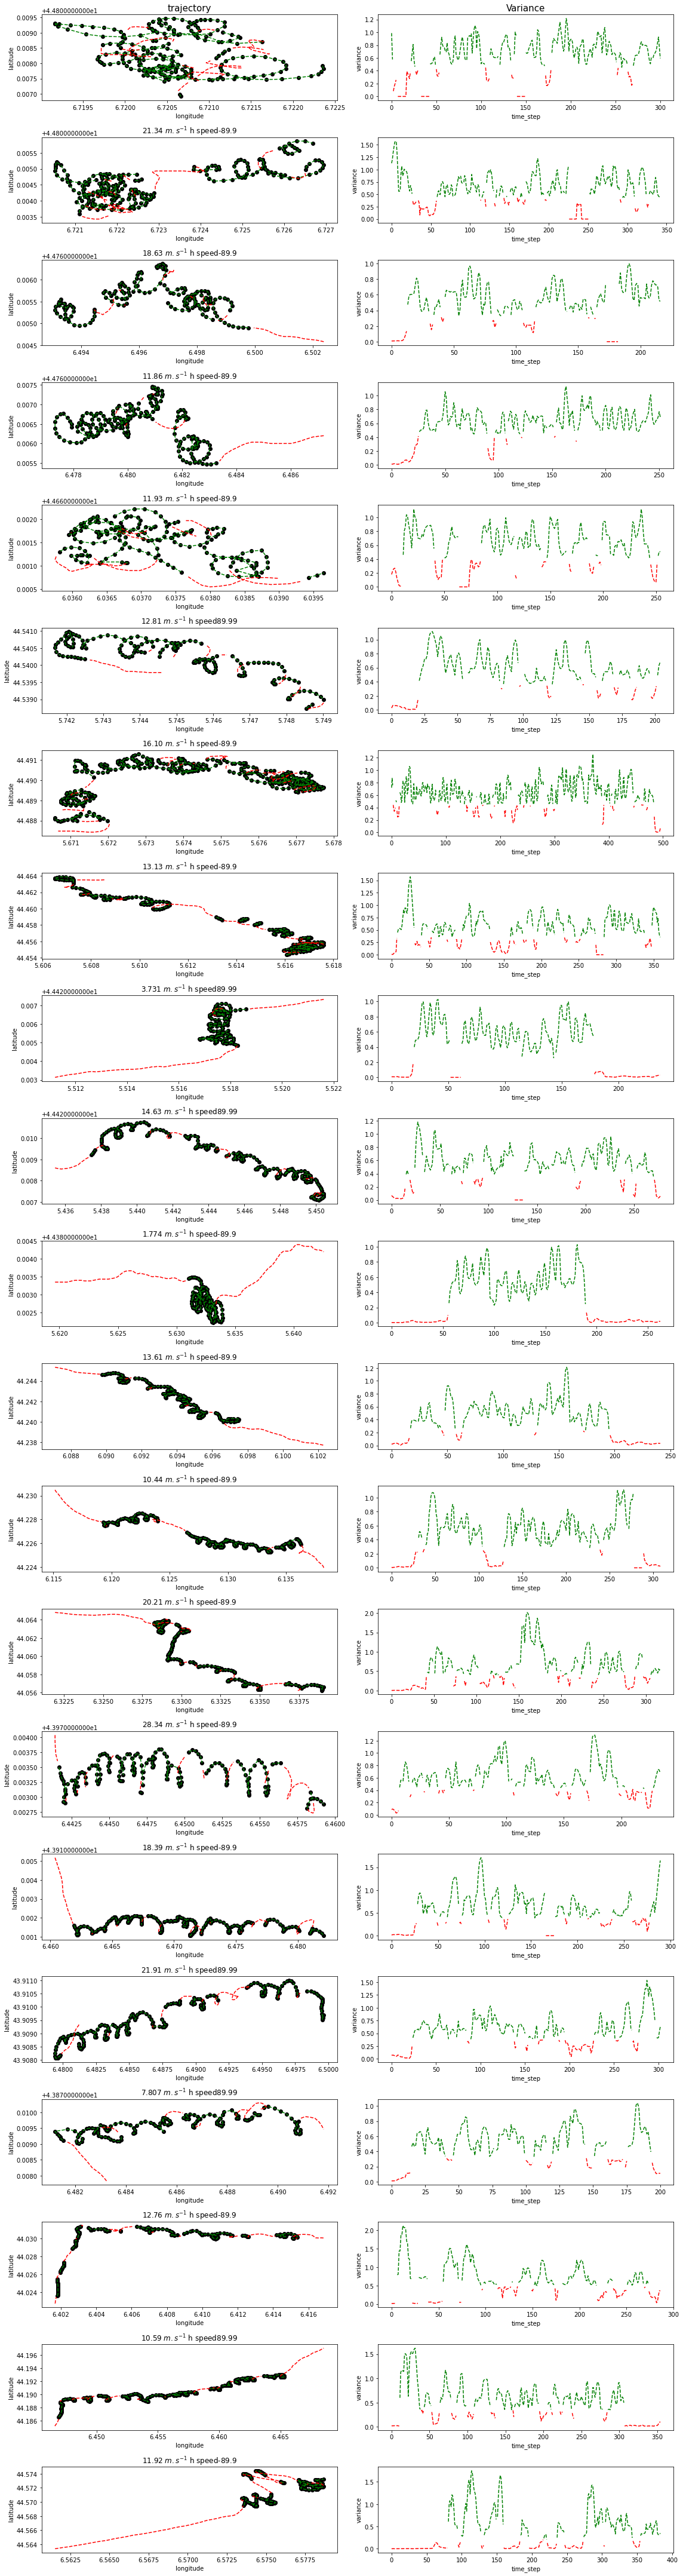

In [155]:
fig, axs = plt.subplots(21, 2, figsize=(16, 60))
window_size = 10
threshold = 0.15
model = LinearRegression()
ord_origine = []

extents = find_major_increasing_trends(all_alti)
lats_res= []
lons_res = []
for i in range(42):
    ax = axs[i//2,i%2]
    ext = extents[i//2]
    variance = rolling_variance(theta[0,ext[0]:ext[1]], window_size)
    variance = [0 if np.isnan(x) else x for x in variance]
    ind1 = (variance <= np.mean(variance)-threshold)
    ind2 = (variance > np.mean(variance)-threshold)
    var1 = np.ma.masked_array(variance,mask=ind1)
    var2 = np.ma.masked_array(variance,mask=ind2)

    lon,lat = all_lon[ext[0]:ext[1]-window_size+1], all_lat[ext[0]:ext[1]-window_size+1]
    lon1 = np.ma.masked_array(lon,mask=ind1)
    lon2 = np.ma.masked_array(lon,mask=ind2)
    lat1 = np.ma.masked_array(lat,mask=ind1)
    lat2 = np.ma.masked_array(lat,mask=ind2)
    
    lats_res=[lat1[0],lat1[-1]]
    lons_res=[lon1[0],lon1[-1]]

    lats__ = holala(ind2,lat)
    lons__ = holala(ind2,lon)
    
    mean_speed =  []
    direction = []
    for j in range(len(lons__)):
        slopes = []
        x = np.linspace(1,len(lons__[j]),len(lons__[j]))
        x = x.reshape(-1,1)
        model.fit(x, lons__[j])
        slopes.append(model.coef_[0]) 
        model.fit(x, lats__[j])
        slopes.append(model.coef_[0]) 
        mean_speed.append(np.sqrt((slopes[1]*100*1000)**2 + (slopes[0]*100*1000)**2))
        direction.append(np.arctan(slopes[1]*100*1000/slopes[0]*100*1000)*180/np.pi)
        
    if i%2 == 0:
        for k in range(len(lats__)):
            ax.plot(lons__[k],lats__[k], 'ko')
        ax.set_title(str(np.max(mean_speed))[:5]+' $m.s^{-1}$ h speed' + str(direction[0])[:5])
        ax.plot(lon1,lat1, 'g--')
        ax.plot(lon2,lat2, 'r--')
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
    #        ax.set_title(str(i) + ' ' + str(all_time[extents[i,0]]) + '-' +str(all_time[extents[i,1]]),fontsize=15)
        if i == 0 :
            ax.set_title('trajectory',fontsize=15)
            
    elif i%2 == 1:
        ax.plot(var1, 'g--')
        ax.plot(var2, 'r--')
        ax.set_xlabel('time_step')
        ax.set_ylabel('variance')
        if i == 1:  
            ax.set_title('Variance',fontsize=15)
    #        ax.set_title(str(percent))

plt.tight_layout()
plt.show()

In [295]:
def thermals_plot(all_lon,all_lat,all_lon_thermal,all_lat_thermal,mean_speed_tot): 
    
    fig = plt.figure(figsize=(15,10))
#    ax = plt.axes(projection=ccrs.PlateCarree())
    img_extent = (4.7942, 8.1545, 43.3545, 46.6707)

    fname = 'C:/Users/barroisl/Documents/Stage_Léo/Satellites/Images_MODIS_VIIRS/Alp_2023-08-20_12H28.jpg'

#    img = plt.imread(fname)
    
#    ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())
    plt.scatter(all_lon,all_lat,s=0.1,color = 'darkorange')
    for i in range(len(all_lon_thermal)):
        for j in range(len(all_lon_thermal[i])):
            plt.scatter(all_lon_thermal[i][j],all_lat_thermal[i][j],s=2,c = [mean_speed_tot[i][j] for k in range(len(all_lon_thermal[i][j]))],cmap = 'coolwarm',vmin=0,vmax=20)
    
    plt.colorbar()
    plt.show()
    
def thermals_plot_vect(all_lon,all_lat,all_lon_thermal,all_lat_thermal,mean_speed_tot,slopes_tot): 
    
    fig = plt.figure(figsize=(15,10))
#    ax = plt.axes(projection=ccrs.PlateCarree())
    img_extent = (4.7942, 8.1545, 43.3545, 46.6707)

    fname = 'C:/Users/barroisl/Documents/Stage_Léo/Satellites/Images_MODIS_VIIRS/Alp_2023-08-20_12H28.jpg'

#    img = plt.imread(fname)
    
#    ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())
    plt.scatter(all_lon,all_lat,s=0.1,color = 'darkorange')
    for i in range(len(all_lon_thermal)):
        for j in range(len(all_lon_thermal[i])):
#            if mean_speed_tot[i][j] > 15 :        
            Q = plt.quiver(all_lon_thermal[i][j], all_lat_thermal[i][j], slopes_tot[i][j][0], slopes_tot[i][j][0], mean_speed_tot[i][j], cmap = 'coolwarm', pivot='mid')
#                qk = plt.quiverkey(Q, 0.01, 0.01, 0.01, r'$1 \frac{m}{s}$', labelpos='E',
#                                   coordinates='figure')
            scatter = plt.scatter(all_lon_thermal[i][j],all_lat_thermal[i][j],s=2,c = [mean_speed_tot[i][j] for k in range(len(all_lon_thermal[i][j]))], cmap = 'coolwarm',vmin=0,vmax=20)
    
    plt.colorbar(scatter)
    plt.show()
            
def thermal_coord(all_lat,all_lon,all_alti,length):
    
    window_size = 10
    threshold = 0.15
    model = LinearRegression()

    extents = find_major_increasing_trends(all_alti,length)
    n = len(extents)
    
    lats_th= []
    lons_th = []
    mean_speed_tot = []
    direction_tot = []
    slopes_tot = []
    for i in range(n):
        ext = extents[i]
        variance = rolling_variance(theta[0,ext[0]:ext[1]], window_size)
        variance = [0 if np.isnan(x) else x for x in variance]
        ind1 = (variance <= np.mean(variance)-threshold)
        ind2 = (variance > np.mean(variance)-threshold)
        var1 = np.ma.masked_array(variance,mask=ind1)
        var2 = np.ma.masked_array(variance,mask=ind2)

        lon,lat = all_lon[ext[0]:ext[1]-window_size+1], all_lat[ext[0]:ext[1]-window_size+1]
        lon1 = np.ma.masked_array(lon,mask=ind1)
        lon2 = np.ma.masked_array(lon,mask=ind2)
        lat1 = np.ma.masked_array(lat,mask=ind1)
        lat2 = np.ma.masked_array(lat,mask=ind2)

        lats__ = holala(ind2,lat)
        lons__ = holala(ind2,lon)
        lats_th.append(lats__)
        lons_th.append(lons__)
        
        slopes = []
        mean_speed = []
        for j in range(len(lons__)):
            direction = []
            x = np.linspace(1,len(lons__[j]),len(lons__[j]))
            x = x.reshape(-1,1)
            model.fit(x, lons__[j])
            slopes_lon = model.coef_[0]
            model.fit(x, lats__[j])
            slopes_lat = model.coef_[0]
            mean_speed.append(np.sqrt((slopes_lat*100*1000)**2 + (slopes_lon*100*1000)**2))
            direction.append(np.arctan(slopes_lat*100*1000/slopes_lon*100*1000)*180/np.pi)
            slopes.append([slopes_lon,slopes_lat])
            
        slopes_tot.append(slopes)
        mean_speed_tot.append(mean_speed)
        direction_tot.append(direction)
        
    return lons_th,lats_th,mean_speed_tot,direction_tot,slopes_tot

In [289]:
lons_th,lats_th,mean_speed_tot,direction_tot,slopes_tot = thermal_coord(all_lat,all_lon,all_alti,30)

C:\Users\barroisl\AppData\Local\Temp\ipykernel_15148\1171244700.py:87: RuntimeWarning: divide by zero encountered in double_scalars
  direction.append(np.arctan(slopes_lat*100*1000/slopes_lon*100*1000)*180/np.pi)


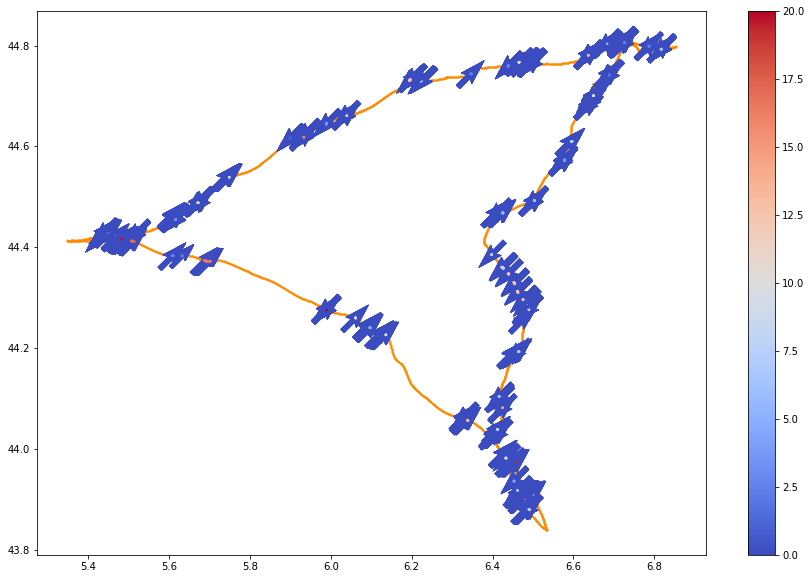

In [296]:
thermals_plot_vect(all_lon,all_lat,lons_th,lats_th,mean_speed_tot,slopes_tot)

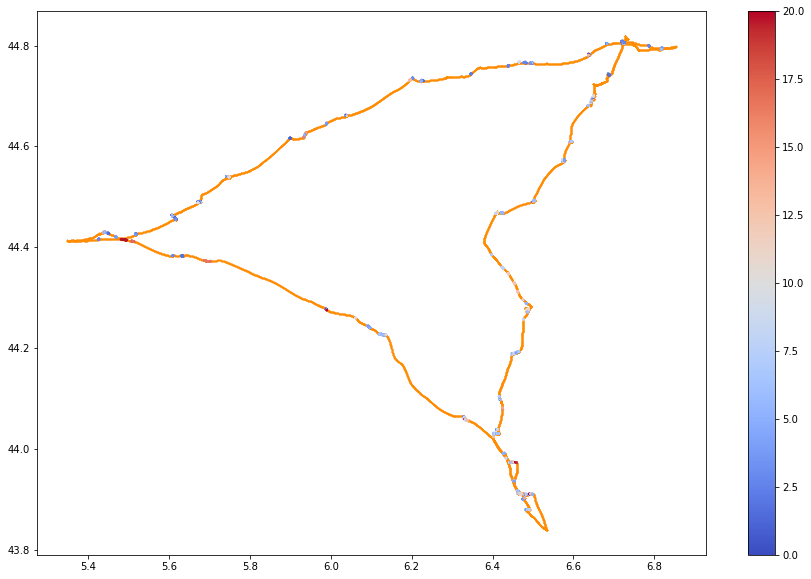

In [226]:
thermals_plot(all_lon,all_lat,lons_th,lats_th,mean_speed_tot)

In [223]:
print(lats_th[0][0])

[44.80681666666667, 44.80675, 44.806666666666665, 44.806583333333336, 44.80648333333333, 44.8064, 44.8063]


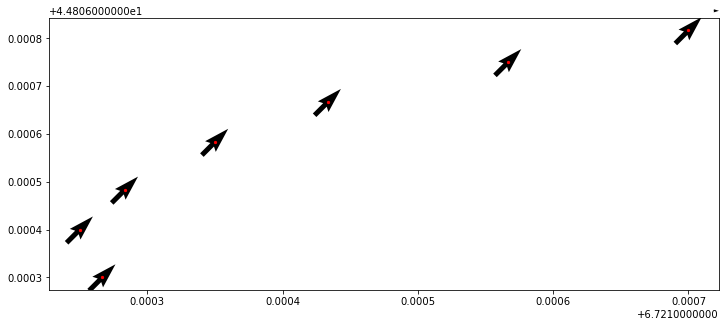

In [224]:
fig = plt.figure(figsize = (12,5))
Q = plt.quiver(lons_th[0][0], lats_th[0][0], [5 for i in range(len(lats_th[0][0]))], [5 for i in range(len(lats_th[0][0]))],
               pivot='mid', units='inches')
qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')
plt.scatter(lons_th[0][0], lats_th[0][0], color='r', s=5)